In [1]:
# Change the working directory
%cd ../..

/mnt/nfs/scratch1/rbialik/adversarial-recommendation-systems


In [2]:
%reload_ext autoreload
import surprise
import numpy as np
import pandas as pd
from scipy import sparse
import src.cf.experiment_core as cf_core

from src.cf.utils.timer import Timer

from src.cf.utils.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_PREDICTION_COL
)

from src.cf.evaluation.eval_metrics_numba import (
    rmse,
    mae,
    precision_at_k,
    recall_at_k
)

from src.models.surprise_cf import * 
from src.models.cf_utils import * 

In [3]:
generated_users_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_1000_user_neighbors_without_reviews_more_sparse.npy'
generated_items_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_1000_item_neighbors_without_reviews_more_sparse.npy'
reviews_generated_users_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_1000_user_neighbors_more_sparse.npy'
reviews_generated_items_file = '/mnt/nfs/scratch1/neerajsharma/model_params/generated_1000_item_neighbors_more_sparse.npy'

In [4]:
vanilla = True
aug = True
reviews_aug = True
cold_start = False

In [5]:
masked_R_coo, unmasked_R_coo, keep_item_idxs = cf_core.get_data_from_dataloader()
mask_coo = sparse.coo_matrix(cf_core.logical_xor(masked_R_coo, unmasked_R_coo))

nnzs = masked_R_coo.getnnz(axis=1)
warm_users = nnzs > 2

loading the data... took 5.938974922057241 seconds for loading the dataset.


In [6]:
aug_masked_R_coo, aug_unmasked_R_coo, aug_mask_coo, generated_users, generated_items = \
    make_aug_data(
        masked_R_coo, 
        unmasked_R_coo, 
        keep_item_idxs, 
        mask_coo, warm_users, 
        generated_users_file, 
        generated_items_file)
reviews_aug_masked_R_coo, reviews_aug_unmasked_R_coo, reviews_aug_mask_coo, reviews_generated_users, reviews_generated_items = \
    make_aug_data(
        masked_R_coo, 
        unmasked_R_coo, 
        keep_item_idxs, 
        mask_coo, warm_users, 
        reviews_generated_users_file, 
        reviews_generated_items_file)

In [7]:
print("\n vanilla data")
mask_csr = mask_coo.tocsr()
unmasked_vals_csr = unmasked_R_coo.multiply(mask_coo)
unmasked_vals_coo = sparse.coo_matrix(unmasked_vals_csr)
unmasked_cold_coo = cf_core.only_cold_start(masked_R_coo, unmasked_vals_coo, warm_users)
print("\n augmented data")
aug_mask_csr = aug_mask_coo.tocsr()
aug_unmasked_vals_csr = aug_unmasked_R_coo.multiply(aug_mask_coo)
aug_unmasked_vals_coo = sparse.coo_matrix(aug_unmasked_vals_csr)
aug_unmasked_cold_coo = cf_core.only_cold_start(aug_masked_R_coo, aug_unmasked_vals_coo, warm_users)
print("\n augmented (+review) data")
reviews_aug_mask_csr = reviews_aug_mask_coo.tocsr()
reviews_aug_unmasked_vals_csr = reviews_aug_unmasked_R_coo.multiply(reviews_aug_mask_coo)
reviews_aug_unmasked_vals_coo = sparse.coo_matrix(reviews_aug_unmasked_vals_csr)
reviews_aug_unmasked_cold_coo = cf_core.only_cold_start(reviews_aug_masked_R_coo, reviews_aug_unmasked_vals_coo, warm_users)


 vanilla data
num users total =  62926
num cold start users =  35946

 augmented data
num users total =  63926
num cold start users =  36946

 augmented (+review) data
num users total =  63926
num cold start users =  36946


In [8]:
if reviews_aug:
    reviews_aug_trainset, reviews_aug_testset, reviews_aug_cold_testset = setup(reviews_aug_masked_R_coo, reviews_aug_unmasked_vals_coo, reviews_aug_unmasked_cold_coo)
if aug:
    aug_trainset, aug_testset, aug_cold_testset = setup(aug_masked_R_coo, aug_unmasked_vals_coo, aug_unmasked_cold_coo)
if vanilla:
    trainset, testset, cold_testset = setup(masked_R_coo, unmasked_vals_coo, unmasked_cold_coo)

make train and test sets...done in 18 seconds
make train and test sets...done in 8 seconds
make train and test sets...done in 2 seconds


In [9]:
if vanilla:
    SVD_vanilla = Model(
        name='SVD (vanilla)', 
        algo=SVD(verbose=False), 
        ks=5, 
        ground_truth=unmasked_vals_coo, 
        mask=mask_coo, 
        ground_truth_cold=unmasked_cold_coo,
        trainset=trainset,
        testset=testset,
        cold_testset=cold_testset)
    SVD_vanilla.train()
    SVD_vanilla.get_diy_predictions()

training  SVD (vanilla) ... done in  10 seconds


In [20]:
if aug:
    SVD_aug = Model(
        name='SVD (augmented)', 
        algo=SVD(verbose=False), 
        ks=5, 
        ground_truth=aug_unmasked_vals_coo, 
        mask=aug_mask_coo, 
        ground_truth_cold=aug_unmasked_cold_coo,
        trainset=aug_trainset,
        testset=aug_testset,
        cold_testset=aug_cold_testset)

    SVD_aug.train()
    SVD_aug.get_diy_predictions()
    SVD_aug.refined_predictions = refine_ratings(
        SVD_aug.trainset.ur, 
        SVD_aug.trainset.ir, 
        SVD_aug.full_prediction_matrix.copy(), 
        generated_users,
        generated_items, .3
    )

training  SVD (augmented) ... done in  238 seconds
refining...refining changed output by at least 2.6276479570168076
refining changed output by at least 2.5923585256839763
refining changed output by at least 2.439708452968188
refining changed output by at least 2.5031220731312667
refining changed output by at least 2.587491745605182
refining changed output by at least 2.445884871092166
refining changed output by at least 2.455332774825935
refining changed output by at least 2.6654234693381316
refining changed output by at least 2.4864720648676295
refining changed output by at least 2.6164502287058315
refining changed output by at least 2.5797682337215333
refining changed output by at least 2.5712409231342104
refining changed output by at least 2.5732069136425997
refining changed output by at least 2.4976239794104864
refining changed output by at least 3.352544763687633
refining changed output by at least 2.5746213277086905
refining changed output by at least 2.604799961269361
refining 

In [19]:
if reviews_aug:
    SVD_aug_reviews = Model(
        name='SVD (augmented w/ reviews)', 
        algo=SVD(verbose=False), 
        ks=5, 
        ground_truth=reviews_aug_unmasked_vals_coo, 
        mask=reviews_aug_mask_coo, 
        ground_truth_cold=reviews_aug_unmasked_cold_coo,
        trainset=reviews_aug_trainset,
        testset=reviews_aug_testset,
        cold_testset=reviews_aug_cold_testset)
        
    SVD_aug_reviews.train()
    SVD_aug_reviews.get_diy_predictions()
    SVD_aug_reviews.refined_predictions = refine_ratings(
        SVD_aug_reviews.trainset.ur, 
        SVD_aug_reviews.trainset.ir, 
        SVD_aug_reviews.full_prediction_matrix.copy(), 
        reviews_generated_users,
        reviews_generated_items, .3
    )

training  SVD (augmented w/ reviews) ... done in  622 seconds
refining...refining changed output by at least 2.678310701906975
refining changed output by at least 2.662105875547499
refining changed output by at least 2.5819242588225166
refining changed output by at least 2.7184257059409296
refining changed output by at least 3.1135162041933957
refining changed output by at least 2.6739024378614964
refining changed output by at least 2.677850650864819
refining changed output by at least 2.6825111066548395
refining changed output by at least 2.435333976786533
refining changed output by at least 2.6784769172325675
refining changed output by at least 2.7201421595969792
refining changed output by at least 2.7602828154632477
refining changed output by at least 2.681780263229606
refining changed output by at least 2.6439396981661565
refining changed output by at least 2.709938889043661
refining changed output by at least 2.5770952570446233
refining changed output by at least 2.634635485074625

In [21]:
models = []
if vanilla:
    models.append(SVD_vanilla)
if aug:
    models.append(SVD_aug)
if reviews_aug:
    models.append(SVD_aug_reviews)

for i, model in enumerate(models):
    print(model.name)
    ground_truth = model.ground_truth.toarray() if not cold_start else model.ground_truth_cold.toarray()
    if 'aug' in model.name:
        model.refined_rmse = rmse(ground_truth, model.refined_predictions)
        model.refined_mae = mae(ground_truth, model.refined_predictions)
    model.rmse = rmse(ground_truth, model.full_prediction_matrix)
    model.mae = mae(ground_truth, model.full_prediction_matrix)
    models[i] = model

SVD (vanilla)
SVD (augmented)
SVD (augmented w/ reviews)


In [22]:
labels = []
errors = []
for model in models:
    labels.append(model.name)
    errors.append([model.mae, model.rmse])
    if 'aug' in model.name:
        labels.append('refined ' + model.name)
        errors.append([model.refined_mae, model.refined_rmse])
user_type = 'all users' if not cold_start else 'cold start'
error_labels = [user_type] + ['MAE', 'RMSE']
tab_data = [[labels[i]] + errors[i] for i in range(len(labels))]
print(tabulate(tab_data, headers=error_labels, tablefmt="github"))

| cold start                         |      MAE |    RMSE |
|------------------------------------|----------|---------|
| SVD (vanilla)                      | 0.739796 | 1.02101 |
| SVD (augmented)                    | 0.792305 | 1.07904 |
| refined SVD (augmented)            | 0.814181 | 1.11126 |
| SVD (augmented w/ reviews)         | 0.737568 | 1.09294 |
| refined SVD (augmented w/ reviews) | 0.757434 | 1.11877 |


In [23]:
for i, model in enumerate(models):
    if 'aug' not in model.name:
        trainset_df = cf_core.surprise_trainset_to_df(model.trainset)
        model.trainset_uid, model.trainset_iid = trainset_df['userID'].to_numpy(), trainset_df['itemID'].to_numpy()
    elif 'reviews' in model.name:
        reviews_aug_trainset_df = cf_core.surprise_trainset_to_df(reviews_aug_trainset)
        model.trainset_uid, model.trainset_iid = reviews_aug_trainset_df['userID'].to_numpy(), reviews_aug_trainset_df['itemID'].to_numpy()
    else:
        aug_trainset_df = cf_core.surprise_trainset_to_df(aug_trainset)
        model.trainset_uid, model.trainset_iid = aug_trainset_df['userID'].to_numpy(), aug_trainset_df['itemID'].to_numpy()
    models[i] = model

In [24]:
for i, model in enumerate(models):
    model.precisions = []
    model.recalls = []
    model.refined_precisions = []
    model.refined_recalls =[]
    ground_truth = model.ground_truth.toarray() if not cold_start else model.ground_truth_cold.toarray()
    for k in range(1,16):
        model.precisions.append(precision_at_k(
            ground_truth, 
            model.full_prediction_matrix, 
            model.trainset_uid, 
            model.trainset_iid,
            relevancy_method='top_k', 
            k=k, 
            threshold=0
        ))
        model.recalls.append(recall_at_k(
            ground_truth, 
            model.full_prediction_matrix, 
            model.trainset_uid, 
            model.trainset_iid,
            relevancy_method='top_k', 
            k=k, 
            threshold=0
        ))
        if 'aug' in model.name:
            model.refined_precisions.append(precision_at_k(
                ground_truth, 
                model.refined_predictions, 
                model.trainset_uid, 
                model.trainset_iid,
                relevancy_method='top_k', 
                k=k, 
                threshold=0
            ))
            model.refined_recalls.append(recall_at_k(
                ground_truth, 
                model.refined_predictions, 
                model.trainset_uid, 
                model.trainset_iid,
                relevancy_method='top_k', 
                k=k, 
                threshold=0
            ))
    models[i] = model

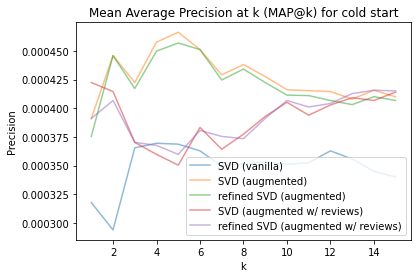

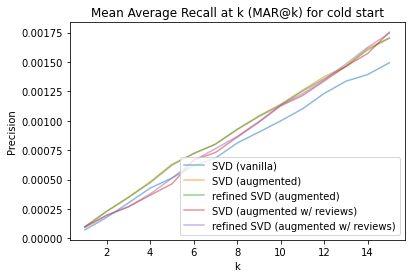

In [25]:
MAPs = []
MARs = []
labels = []
for model in models:
    labels.append(model.name)
    MAPs.append(model.precisions)
    MARs.append(model.recalls)
    if 'aug' in model.name:
        labels.append('refined ' + model.name)
        MAPs.append(model.refined_precisions)
        MARs.append(model.refined_recalls)

ks = list(range(1, 16))
for i in range(len(labels)):
    plt.plot(ks, MAPs[i], label=labels[i], alpha=.5)

plt.title(f'Mean Average Precision at k (MAP@k) for {user_type}')
plt.xlabel('k')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()


ks = list(range(1, 16))
for i in range(len(labels)):
    plt.plot(ks, MARs[i], label=labels[i], alpha=.5)

plt.title(f'Mean Average Recall at k (MAR@k) for {user_type}')
plt.xlabel('k')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()